In [1]:
import numpy as np
import pandas as pd

In [2]:
import pystan
print pystan.__version__

2.9.0.0


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [4]:
import bz2
try:
    import cPickle as pickle
except:
    import pickle

In [5]:
import os
import sys
import inspect
cmd_folder = os.path.realpath(
        os.path.abspath(
            os.path.split(
                inspect.getfile(
                    inspect.currentframe()
                )
            )[0]
        )
    )
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

# Logistic Regression Classifier

In [6]:
from sklearn import linear_model

In [10]:
# a most artificial training set
xmin, xmax = -5, 5
n_train_samples = 3000
n_unlabelled_samples = 300
np.random.seed(0)
def gen_X(n):
    return np.concatenate(
            (np.random.normal(loc=5.0, scale=2.5, size=n/3),
             np.random.normal(loc=15.0, scale=2.5, size=2*n/3)))
X_train = gen_X(n_train_samples)
X_unlabelled = gen_X(n_unlabelled_samples)
y_train = np.concatenate(
    (np.full(n_train_samples/3, 0, dtype=np.int64),
     np.full(2*n_train_samples/3, 1, dtype=np.int64)))
X_train = X_train[:, np.newaxis]

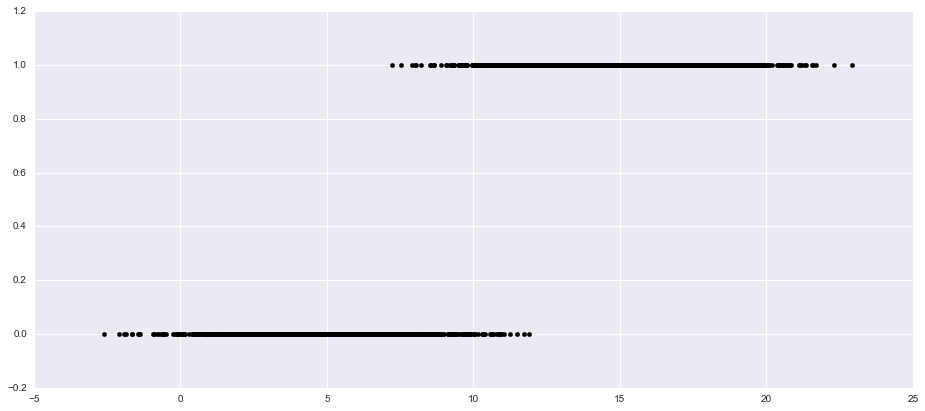

In [11]:
# plot of the training data
plt.figure(1, figsize=(.75*21., .75*9.))
plt.scatter(X_train.ravel(), y_train, color='black')

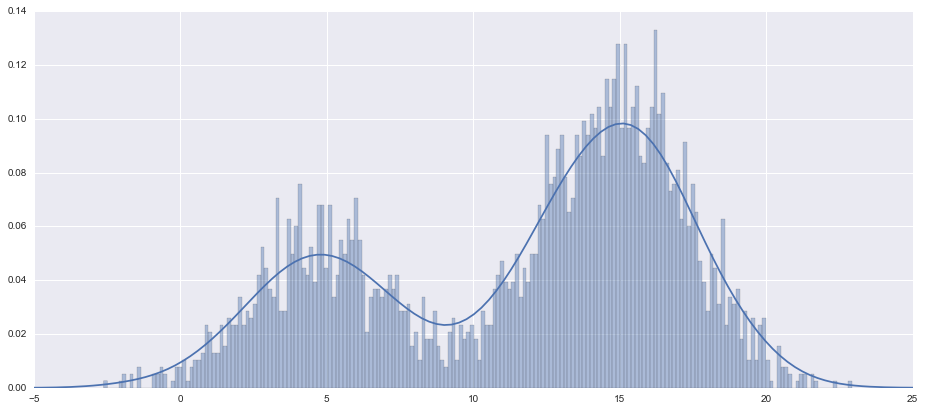

In [12]:
# histogram of the training data
plt.figure(1, figsize=(.75*21., .75*9.))
plt.xlim(-5, 25)
sns.distplot(X_train, bins=200)

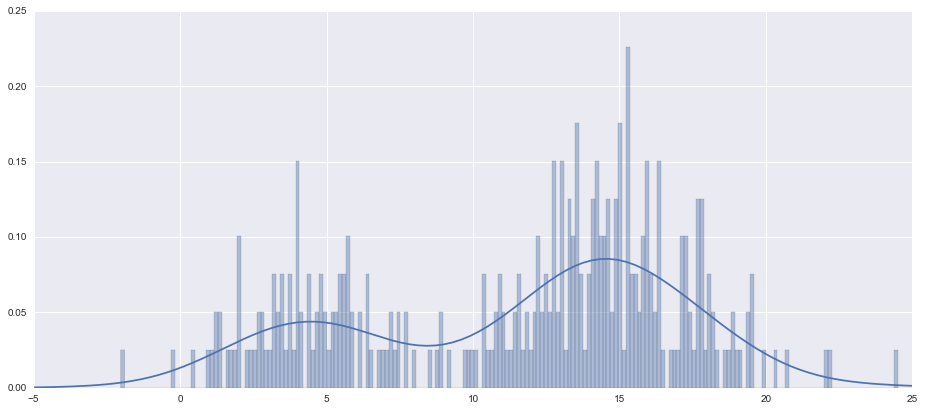

In [13]:
# histogram of the unlabelled data
plt.figure(1, figsize=(.75*21., .75*9.))
plt.xlim(-5, 25)
sns.distplot(X_unlabelled, bins=200)

In [14]:
# run the classifier
clf = linear_model.LogisticRegression(C=1e0, penalty='l2')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# get probabilities for a test set
X_test = np.linspace(-10, 30, 5001)
y_test = sigmoid(X_test * clf.coef_ + clf.intercept_).ravel()

# get predictions for the unlabelled samples
y_unlabelled = clf.predict(X_unlabelled[:, np.newaxis])
y_unlabelled

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

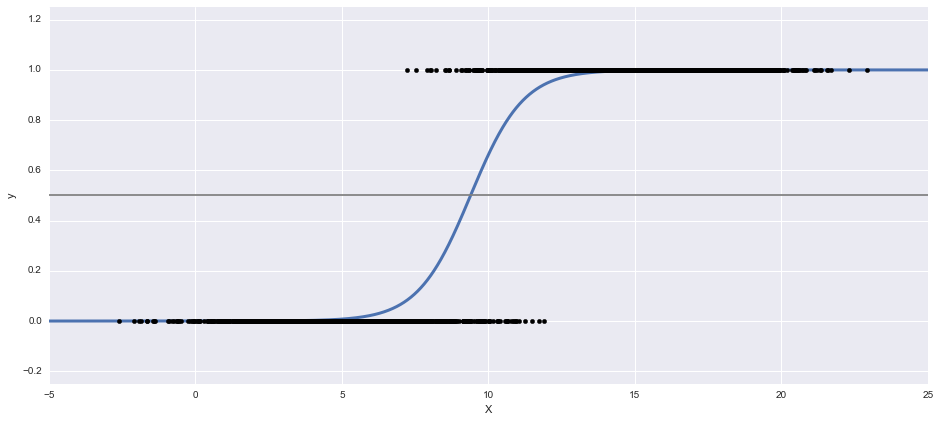

In [16]:
# plot everything
plt.figure(1, figsize=(.75*21., .75*9.))

# predictions
plt.plot(X_test, y_test, linewidth=3)

# demarcation line
plt.axhline(.5, color='.5')

# training data
plt.scatter(X_train.ravel(), y_train, color='black', zorder=3)

plt.ylabel('y')
plt.xlabel('X')
plt.ylim(-.25, 1.25)
plt.xlim(-5, 25)

plt.show()

# Bayesian Leaning of Classifiers

In [17]:
def supervised_inference(train, alpha=1.0, mu0=0., kappa0=1.0,
                         a0=0.5, b0=0.5, iter=1000, warmup=500, chains=16):
    """Estimation with class-labeled training data"""
    
    classes = train.index.values.tolist()
    train = train.reset_index(drop=True)

    stan_data = {}
    
    stan_data['K'] = len(train.index)
    stan_data['D'] = len(train.columns)
    
    # labelled training data
    stan_data['c'] = np.concatenate(
            [(idx+1)*np.ones(np.array(row.tolist()).shape[1], dtype=np.int64)
                    for idx, row in train.iterrows()])
    stan_data['x'] = np.concatenate(
            [np.array(row.tolist()).transpose()
                     for _, row in train.iterrows()])
    stan_data['N'] = stan_data['x'].shape[0]
    
    # hyperparameters
    stan_data['alpha'] = alpha*np.ones(stan_data['K'])
    stan_data['mu0'] = mu0
    stan_data['kappa0'] = kappa0
    stan_data['a0'] = a0
    stan_data['b0'] = b0

    stan_code = """
data {
    int<lower=1> K;              // number of classes
    int<lower=1> D;              // number of features
    // labelled training data
    int<lower=0> N;              // number of labelled observations
    int<lower=1,upper=K> c[N];   // classes for labelled observations
    vector[D] x[N];              // features for labelled observations
    // hyperparameters
    vector<lower=0>[K] alpha;    // class concentration
    real mu0;                    // prior mean
    real<lower=0> kappa0;        // prior sample size
    real<lower=0> a0;            // shape
    real<lower=0> b0;            // rate
}
parameters {
    simplex[K] pi;                   // class prevalence
    vector[D] mu[K];                 // means of features
    vector<lower=0>[D] invsigmasqr;  // inverse variances of features
}
transformed parameters {
    vector<lower=0>[D] sigma;    // scales of features
    for (i in 1:D)
        sigma[i] <- inv_sqrt(invsigmasqr[i]);
}
model {
    pi ~ dirichlet(alpha);       // class prevalence prior
    for (n in 1:N)
        c[n] ~ categorical(pi);  // class indicator prior
    for (k in 1:K)
        mu[k] ~ normal(mu0, sigma/sqrt(kappa0));
    for (i in 1:D)
        invsigmasqr[i] ~ gamma(a0, b0);
                                 // base measures
    for (n in 1:N)
        x[n] ~ normal(mu[c[n]], sigma);
                                 // generative model
}
"""
    
    sm = pystan.StanModel(model_code=stan_code)

    fit = sm.sampling(data=stan_data, iter=iter, warmup=warmup, chains=chains)
    op = sm.optimizing(data=stan_data)
    
    return classes, fit, op

In [18]:
def supervised_inference_mk2(train, alpha=1.0, mu0=0., kappa0=1.0,
                             iter=1000, warmup=500, chains=16):
    """Estimation with class-labeled training data"""
    
    classes = train.index.values.tolist()
    train = train.reset_index(drop=True)

    stan_data = {}
    
    stan_data['K'] = len(train.index)
    stan_data['D'] = len(train.columns)
    
    # labelled training data
    stan_data['c'] = np.concatenate(
            [(idx+1)*np.ones(np.array(row.tolist()).shape[1], dtype=np.int64)
                    for idx, row in train.iterrows()])
    stan_data['x'] = np.concatenate(
            [np.array(row.tolist()).transpose()
                     for _, row in train.iterrows()])
    stan_data['N'] = stan_data['x'].shape[0]
    
    # hyperparameters
    stan_data['alpha'] = alpha*np.ones(stan_data['K'])
    stan_data['mu0'] = mu0
    stan_data['kappa0'] = kappa0

    stan_code = """
functions {
    real alpha_jeffreys_log(real x) {
        return log(sqrt(x * trigamma(x) - 1));
    }
}
data {
    int<lower=1> K;              // number of classes
    int<lower=1> D;              // number of features
    // labelled training data
    int<lower=0> N;              // number of labelled observations
    int<lower=1,upper=K> c[N];   // classes for labelled observations
    vector[D] x[N];              // features for labelled observations
    // hyperparameters
    vector<lower=0>[K] alpha;    // class concentration
    real mu0;                    // prior mean
    real<lower=0> kappa0;        // prior sample size
}
parameters {
    simplex[K] pi;                   // class prevalence
    vector[D] mu[K];                 // means of features
    vector<lower=0>[D] invsigmasqr;  // inverse variances of features
    real<lower=0> a0;                // shape
    real logb0;                      // rate
}
transformed parameters {
    vector<lower=0>[D] sigma;    // scales of features
    real<lower=0> b0;    
    for (i in 1:D)
        sigma[i] <- inv_sqrt(invsigmasqr[i]);    
    b0 <- exp(logb0);            // logb0 is uniformly distributed
}
model {
    pi ~ dirichlet(alpha);       // class prevalence prior
    for (n in 1:N)
        c[n] ~ categorical(pi);  // class indicator prior
    for (k in 1:K)
        mu[k] ~ normal(mu0, sigma/sqrt(kappa0));
    a0 ~ alpha_jeffreys();       // Jeffreys prior for a0 and b0
    for (i in 1:D)
        invsigmasqr[i] ~ gamma(a0, b0);
                                 // base measures
    for (n in 1:N)
        x[n] ~ normal(mu[c[n]], sigma);
                                 // generative model
}
"""
    
    sm = pystan.StanModel(model_code=stan_code)

    fit = sm.sampling(data=stan_data, iter=iter, warmup=warmup, chains=chains)
    op = sm.optimizing(data=stan_data)
    
    return classes, fit, op

In [19]:
observations = pd.DataFrame(np.concatenate((X_train.ravel(), X_test)),
                            columns=['X'])
observations['y'] = np.concatenate((y_train.astype('S7'), np.full(
            X_test.shape[0], 'unknown', dtype='S7')))

In [20]:
agg_list = lambda x: list(x.values.astype(np.float64))
agg_dict = {'X': agg_list}
observationsGroupedByY = observations.groupby('y').aggregate(agg_dict)

In [21]:
train = observationsGroupedByY.loc[['0', '1']]
test = observationsGroupedByY.loc['unknown']

In [22]:
_, demo_fit, _ = supervised_inference(train, iter=1000, warmup=500, chains=1)
demo_samples = demo_fit.extract(permuted=True)

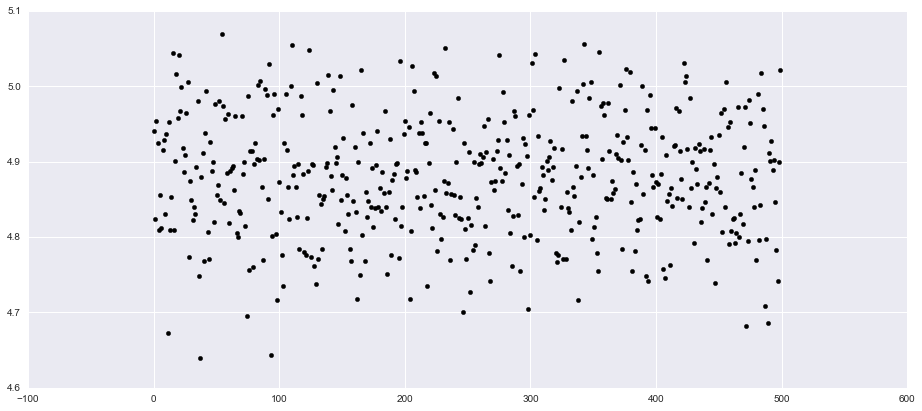

In [23]:
plt.figure(1, figsize=(.75*21., .75*9.))
plt.scatter(range(500), demo_samples['mu'][:, 0].ravel()[:500], color='black')

\begin{align}
    \rho_k = \frac{\sum_{i=1}^{n-k} \left(x_i - \bar{x}\right) \left(x_{i+k} - \bar{x}\right)}{\sum_{i=1}^n \left(x_i - \bar{x}\right)^2}
\end{align}

In [24]:
def lags(samples):
    n = len(samples)
    mean = np.mean(samples)
    var = np.var(samples, ddof=n-1)
    ret = np.zeros((n,), dtype=np.float64)
    for k in range(n):
        for i in range(n-k):
            ret[k] += (samples[i] - mean) * (samples[i+k] - mean)
    return ret / var

In [25]:
demo_lags = lags(demo_samples['mu'][:, 0].ravel())

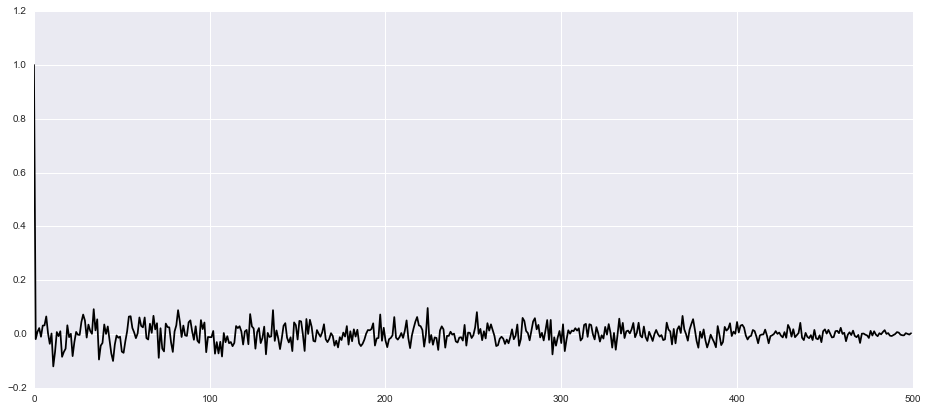

In [26]:
plt.figure(1, figsize=(.75*21., .75*9.))
plt.plot(range(500), demo_lags[:500], color='black')

In [27]:
# get samples from simple model

fname = cmd_folder + '/making_a_stan__supervised_inference.pkl.bz2'

try:
    fp = bz2.BZ2File(fname)
    classes, samples, op = pickle.load(fp)
    fp.close()
except:
    classes, fit, op = supervised_inference(
            train, iter=1000, warmup=500, chains=16)
    samples = fit.extract(permuted=True)
    fp = bz2.BZ2File(fname, 'w')
    pickle.dump([classes, samples, op], fp, pickle.HIGHEST_PROTOCOL)
    fp.close()

In [28]:
# get samples from advanced model

fname = cmd_folder + '/making_a_stan__supervised_inference_mk2.pkl.bz2'

try:
    fp = bz2.BZ2File(fname)
    classes, samples, op = pickle.load(fp)
    fp.close()
except:
    classes, fit, op = supervised_inference_mk2(
            train, iter=1000, warmup=500, chains=16)
    samples = fit.extract(permuted=True)
    fp = bz2.BZ2File(fname, 'w')
    pickle.dump([classes, samples, op], fp, pickle.HIGHEST_PROTOCOL)
    fp.close()

In [29]:
samples_mu0 = samples['mu'][:, 0].ravel()
samples_mu1 = samples['mu'][:, 1].ravel()

In [30]:
np.mean(samples_mu0)

4.8701713691713433

In [31]:
np.mean(samples_mu1)

14.945153273717834

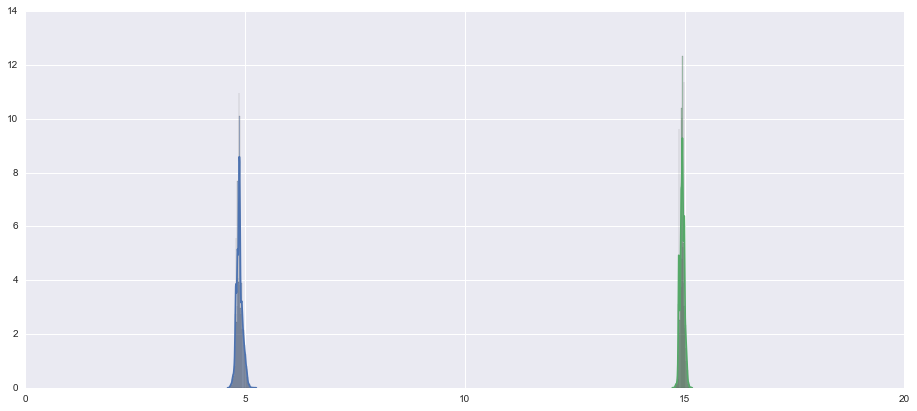

In [32]:
plt.figure(1, figsize=(.75*21., .75*9.))
plt.xlim(0, 20)
sns.distplot(samples_mu0)
sns.distplot(samples_mu1)

In [33]:
def get_prob(lift):
    return np.mean((samples_mu1 - samples_mu0) / samples_mu0 > lift)
v_get_prob = np.vectorize(get_prob)
x = np.linspace(0., 3., 1000)
prob = v_get_prob(x)

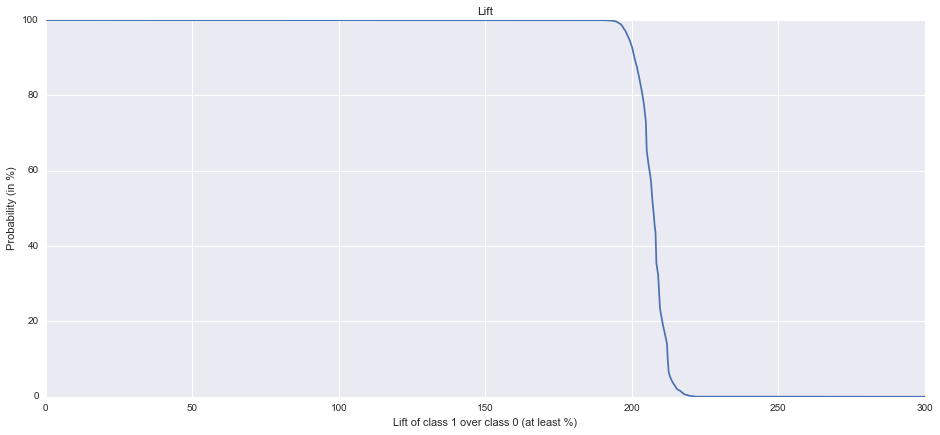

In [34]:
fig, ax = plt.subplots(figsize=(.75*21., .75*9.))

plt.plot(x*100, prob*100)

ax.set_title('Lift')
plt.xlabel(r'Lift of class 1 over class 0 (at least %)')
plt.ylabel(r'Probability (in %)')

plt.show()

In [35]:
np.mean(samples['sigma'].ravel())

2.446842270304753

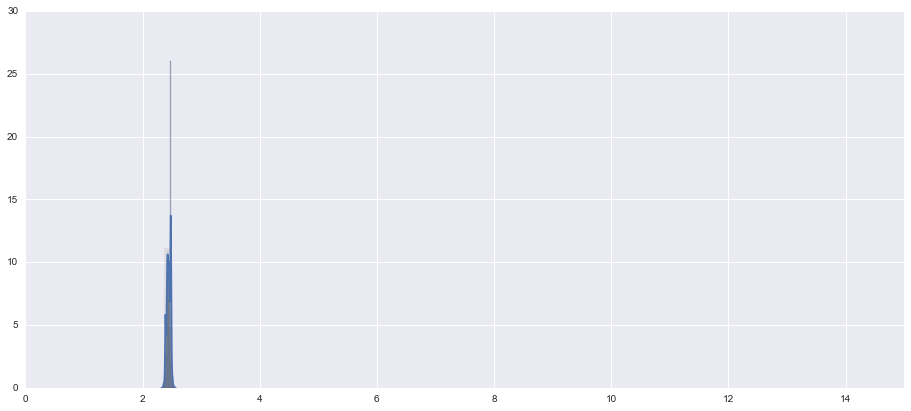

In [36]:
plt.figure(1, figsize=(.75*21., .75*9.))
plt.xlim(0, 15)
sns.distplot(samples['sigma'].ravel())

# Bayesian prediction without model updates

In [37]:
def full_bayesian_inference_without_updates(train, test, alpha=1.0, mu0=0.,
                                            kappa0=1.0, a0=0.5, b0=0.5,
                                            iter=1000, warmup=500, chains=16):
    """
    Estimation combining the models for supervised and unsupervised data, but
    without updating the parameter estimates based on the unlabeled data
    """
    
    classes = train.index.values.tolist()
    train = train.reset_index(drop=True)

    stan_data = {}
    
    stan_data['K'] = len(train.index)
    stan_data['D'] = len(train.columns)
    
    # labelled training data
    stan_data['c'] = np.concatenate(
            [(idx+1)*np.ones(np.array(row.tolist()).shape[1], dtype=np.int64)
                    for idx, row in train.iterrows()])
    stan_data['x'] = np.concatenate(
            [np.array(row.tolist()).transpose()
                    for _, row in train.iterrows()])
    stan_data['N'] = stan_data['x'].shape[0]
    
    # unlabelled test data
    stan_data['xp'] = np.array(test.tolist()).transpose()
    stan_data['Np'] = stan_data['xp'].shape[0]
    
    # hyperparameters
    stan_data['alpha'] = alpha*np.ones(stan_data['K'])
    stan_data['mu0'] = mu0
    stan_data['kappa0'] = kappa0
    stan_data['a0'] = a0
    stan_data['b0'] = b0

    stan_code = """
data {
    int<lower=1> K;              // number of classes
    int<lower=1> D;              // number of features
    // labelled training data
    int<lower=0> N;              // number of labelled observations
    int<lower=1,upper=K> c[N];   // classes for labelled observations
    vector[D] x[N];              // features for labelled observations
    // unlabelled test data
    int<lower=0> Np;             // number of unlabelled observations
    vector[D] xp[Np];            // features for unlabelled observations
    // hyperparameters
    vector<lower=0>[K] alpha;    // class concentration
    real mu0;                    // prior mean
    real<lower=0> kappa0;        // prior sample size
    real<lower=0> a0;            // shape
    real<lower=0> b0;            // rate
}
parameters {
    simplex[K] pi;                   // class prevalence
    vector[D] mu[K];                 // means of features
    vector<lower=0>[D] invsigmasqr;  // inverse variances of features
}
transformed parameters {
    vector<lower=0>[D] sigma;    // scales of features
    for (i in 1:D)
        sigma[i] <- inv_sqrt(invsigmasqr[i]);
}
model {
    pi ~ dirichlet(alpha);       // class prevalence prior
    for (n in 1:N)
        c[n] ~ categorical(pi);  // class indicator prior
    for (k in 1:K)
        mu[k] ~ normal(mu0, sigma/sqrt(kappa0));
    for (i in 1:D)
        invsigmasqr[i] ~ gamma(a0, b0);
                                 // base measures
    for (n in 1:N)
        x[n] ~ normal(mu[c[n]], sigma);
                                 // generative model
}
generated quantities {
    vector[K] z[Np];
    vector[K] sm[Np];
    int<lower=1,upper=K> cp[Np];
    for (np in 1:Np) {
        for (k in 1:K)
            z[np, k] <- normal_log(xp[np], mu[k], sigma) \
                + categorical_log(k, pi);
        sm[np] <- softmax(z[np]);
        cp[np] <- categorical_rng(sm[np]);
    }
}
"""
    
    sm = pystan.StanModel(model_code=stan_code)

    fit = sm.sampling(data=stan_data, iter=iter, warmup=warmup, chains=chains)
    op = sm.optimizing(data=stan_data)
    
    return classes, fit, op

In [38]:
# get samples from model without updates

fname = cmd_folder + \
        '/making_a_stan__full_bayesian_inference_without_updates.pkl.bz2'

try:
    fp = bz2.BZ2File(fname)
    classes, samples, op = pickle.load(fp)
    fp.close()
except:
    classes, fit, op = full_bayesian_inference_without_updates(
            train, test, iter=1000, warmup=500, chains=16)
    samples = fit.extract(permuted=True)
    fp = bz2.BZ2File(fname, 'w')
    pickle.dump([classes, samples, op], fp, pickle.HIGHEST_PROTOCOL)
    fp.close()

In [39]:
samples_mu0 = samples['mu'][:, 0].ravel()
samples_mu1 = samples['mu'][:, 1].ravel()

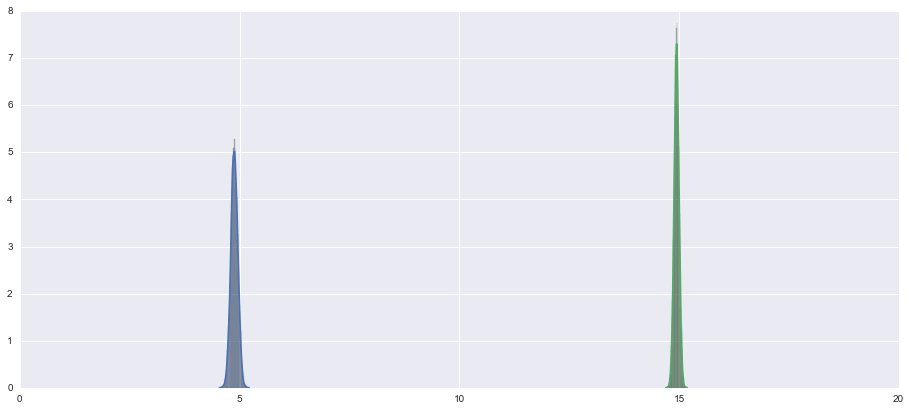

In [40]:
plt.figure(1, figsize=(.75*21., .75*9.))
plt.xlim(0, 20)
sns.distplot(samples_mu0)
sns.distplot(samples_mu1)

In [41]:
X_test[2500]

10.0

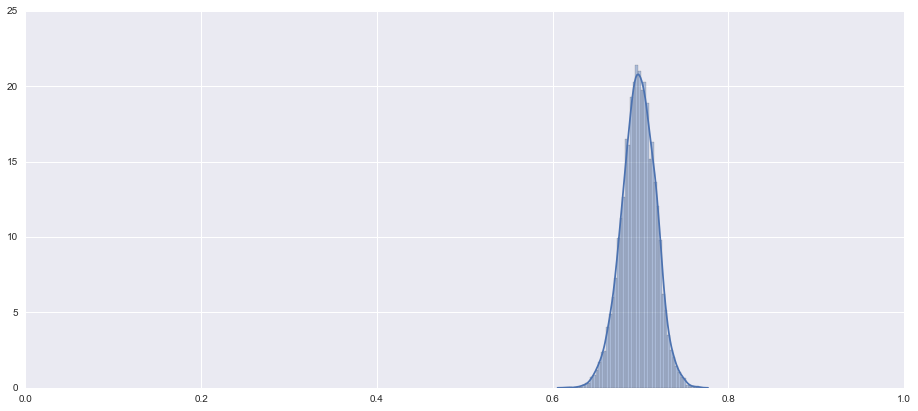

In [42]:
plt.figure(1, figsize=(.75*21., .75*9.))
plt.xlim(0, 1)
sns.distplot(samples['sm'][:, 2500, 1])

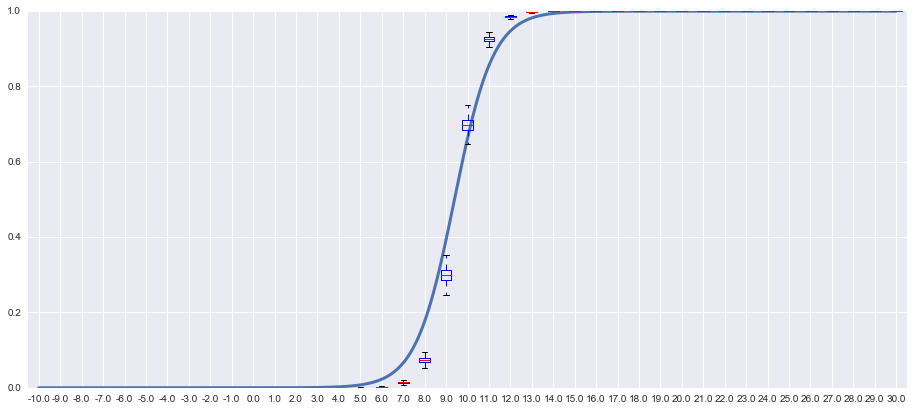

In [43]:
fig, ax = plt.subplots(figsize=(.75*21., .75*9.))
ax.plot(X_test, y_test, linewidth=3)
ax.boxplot(samples['sm'][:, ::125, 1], positions=X_test[::125]);

# Bayesian prediction with model updates

In [44]:
observations = pd.DataFrame(np.concatenate((X_train.ravel(),
                                            X_unlabelled)),
                            columns=['X'])
observations['y'] = np.concatenate((y_train.astype('S7'), np.full(
            X_unlabelled.shape[0], 'unknown', dtype='S7')))

In [45]:
agg_list = lambda x: list(x.values.astype(np.float64))
agg_dict = {'X': agg_list}
observationsGroupedByY = observations.groupby('y').aggregate(agg_dict)

In [46]:
train = observationsGroupedByY.loc[['0', '1']]
test = observationsGroupedByY.loc['unknown']

In [47]:
def full_bayesian_inference(train, test, alpha=1.0, mu0=0., kappa0=1.0,
                            a0=0.5, b0=0.5, iter=1000, warmup=500, chains=16):
    """Estimation combining the models for supervised and unsupervised data"""
    
    classes = train.index.values.tolist()
    train = train.reset_index(drop=True)

    stan_data = {}
    
    stan_data['K'] = len(train.index)
    stan_data['D'] = len(train.columns)
    
    # labelled training data
    stan_data['c'] = np.concatenate(
            [(idx+1)*np.ones(np.array(row.tolist()).shape[1], dtype=np.int64)
                    for idx, row in train.iterrows()])
    stan_data['x'] = np.concatenate(
            [np.array(row.tolist()).transpose()
                    for _, row in train.iterrows()])
    stan_data['N'] = stan_data['x'].shape[0]
    
    # unlabelled test data
    stan_data['xp'] = np.array(test.tolist()).transpose()
    stan_data['Np'] = stan_data['xp'].shape[0]
    
    # hyperparameters
    stan_data['alpha'] = alpha*np.ones(stan_data['K'])
    stan_data['mu0'] = mu0
    stan_data['kappa0'] = kappa0
    stan_data['a0'] = a0
    stan_data['b0'] = b0

    stan_code = """
data {
    int<lower=1> K;              // number of classes
    int<lower=1> D;              // number of features
    // labelled training data
    int<lower=0> N;              // number of labelled observations
    int<lower=1,upper=K> c[N];   // classes for labelled observations
    vector[D] x[N];              // features for labelled observations
    // unlabelled test data
    int<lower=0> Np;             // number of unlabelled observations
    vector[D] xp[Np];            // features for unlabelled observations
    // hyperparameters
    vector<lower=0>[K] alpha;    // class concentration
    real mu0;                    // prior mean
    real<lower=0> kappa0;        // prior sample size
    real<lower=0> a0;            // shape
    real<lower=0> b0;            // rate
}
parameters {
    simplex[K] pi;                   // class prevalence
    vector[D] mu[K];                 // means of features
    vector<lower=0>[D] invsigmasqr;  // inverse variances of features
}
transformed parameters {
    vector<lower=0>[D] sigma;    // scales of features
    vector[K] z[Np];
    for (i in 1:D)
        sigma[i] <- inv_sqrt(invsigmasqr[i]);
    for (np in 1:Np)
        for (k in 1:K)
            z[np, k] <- normal_log(xp[np], mu[k], sigma) \
                    + categorical_log(k, pi);
}
model {
    pi ~ dirichlet(alpha);       // class prevalence prior
    for (n in 1:N)
        c[n] ~ categorical(pi);  // class indicator prior
    for (k in 1:K)
        mu[k] ~ normal(mu0, sigma/sqrt(kappa0));
    for (i in 1:D)
        invsigmasqr[i] ~ gamma(a0, b0);
                                 // base measures
    for (n in 1:N)
        x[n] ~ normal(mu[c[n]], sigma);
                                 // generative model
    for (np in 1:Np)
        increment_log_prob(log_sum_exp(z[np]));
                                 // to do inference on the unlabelled dataset,
                                 // the indicator variables have to be summed
                                 // out
}
generated quantities {
    vector[K] sm[Np];
    int<lower=1,upper=K> cp[Np];
    for (np in 1:Np) {
        sm[np] <- softmax(z[np]);
        cp[np] <- categorical_rng(sm[np]);
    }
}
"""
    
    sm = pystan.StanModel(model_code=stan_code)

    fit = sm.sampling(data=stan_data, iter=iter, warmup=warmup, chains=chains)
    op = sm.optimizing(data=stan_data)
    
    return classes, fit, op

In [48]:
# get samples from model with updates

fname = cmd_folder + \
        '/making_a_stan__full_bayesian_inference.pkl.bz2'

try:
    fp = bz2.BZ2File(fname)
    classes, samples, op = pickle.load(fp)
    fp.close()
except:
    classes, fit, op = full_bayesian_inference(
            train, test, iter=1000, warmup=500, chains=16)
    samples = fit.extract(permuted=True)
    fp = bz2.BZ2File(fname, 'w')
    pickle.dump([classes, samples, op], fp, pickle.HIGHEST_PROTOCOL)
    fp.close()

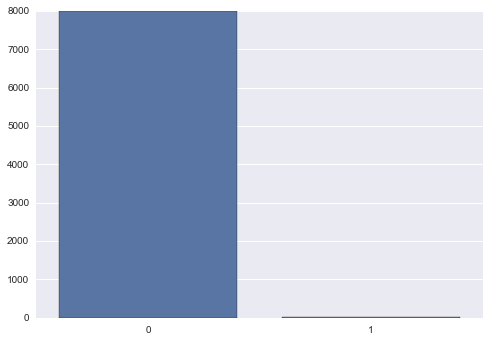

In [49]:
sns.barplot(x=np.array([0,1]),
            y=np.bincount((np.int64(samples['cp']-1.))[:, 50]))

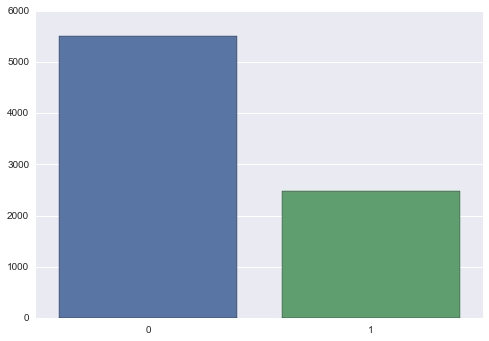

In [50]:
sns.barplot(x=np.array([0,1]),
            y=np.bincount((np.int64(samples['cp']-1.))[:, np.all([X_unlabelled < 10.,
                                                                  X_unlabelled > 7.5],
                                                                 axis=0)][:, 0]))

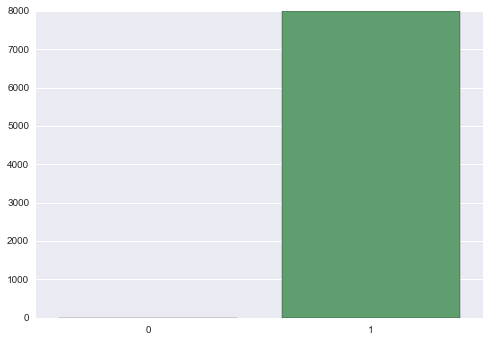

In [51]:
sns.barplot(x=np.array([0,1]),
            y=np.bincount((np.int64(samples['cp']-1.))[:, 250]))

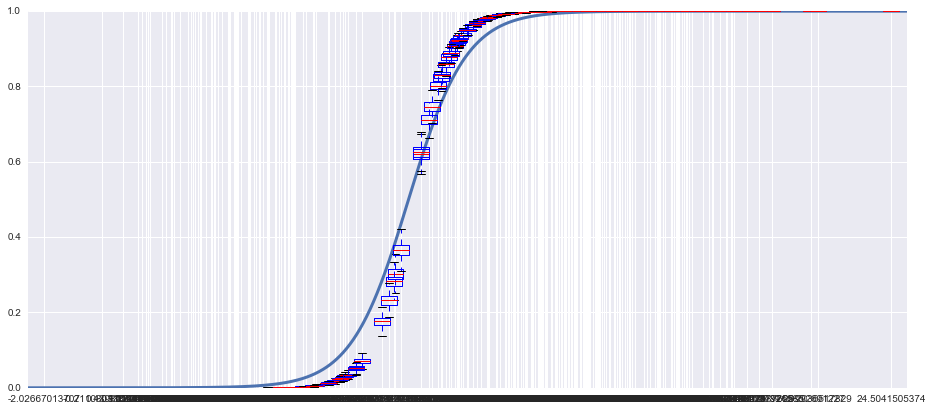

In [52]:
fig, ax = plt.subplots(figsize=(.75*21., .75*9.))
ax.plot(X_test, y_test, linewidth=3)
ax.boxplot(samples['sm'][:, ::1, 1], positions=X_unlabelled[::1]);

# A real application: iPhone 6S Chipgate

http://tscholak.github.io/bayesianism/apple/chipgate/2015/10/14/chipgate.html

In [53]:
observations = pd.read_csv('data/iphone6s.csv', sep='\t')

In [54]:
agg_list = lambda x: list(x.values.astype(np.float64))
agg_dict = {'battery score': agg_list}
observationsGroupedByModel = observations.groupby('model').aggregate(agg_dict)

In [55]:
observationsGroupedByModel

,battery score
model,
"iPhone7,2","[1955.0, 1475.0, 1606.0, 1935.0, 2073.0, 1940...."
"iPhone8,1","[3373.0, 2291.0, 3265.0, 3138.0, 3270.0, 2120...."
"iPhone8,1 (N71AP)","[2453.0, 2211.0, 2536.0, 2443.0, 2313.0, 1470...."
"iPhone8,1 (N71mAP)","[3391.0, 3441.0, 3287.0, 3291.0, 3215.0, 3293.0]"


In [56]:
train = observationsGroupedByModel.loc[['iPhone8,1 (N71AP)',
                                        'iPhone8,1 (N71mAP)']]
test = observationsGroupedByModel.loc['iPhone8,1']

In [57]:
# get samples from model with updates

fname = cmd_folder + \
        '/making_a_stan__chipgate.pkl.bz2'

try:
    fp = bz2.BZ2File(fname)
    classes, samples, op = pickle.load(fp)
    fp.close()
except:
    classes, fit, op = full_bayesian_inference(
            train, test,
            alpha=0.5,
            mu0=observations['battery score'].mean(),
            kappa0=1,
            iter=2000, warmup=1000, chains=16)
    samples = fit.extract(permuted=True)
    fp = bz2.BZ2File(fname, 'w')
    pickle.dump([classes, samples, op], fp, pickle.HIGHEST_PROTOCOL)
    fp.close()

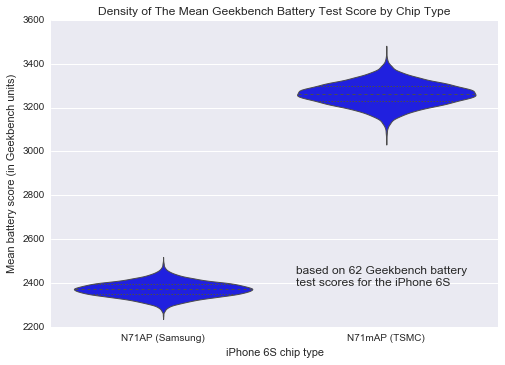

In [61]:
fig, ax = plt.subplots()
ax.set_title('Density of The Mean Geekbench Battery Test Score by Chip Type')
sns.violinplot(
        data=pd.DataFrame(samples['mu'].reshape((samples['mu'].shape[0], samples['mu'].shape[1])),
                          columns=['N71AP (Samsung)', 'N71mAP (TSMC)']),
        color="b", split=True, linewidth=1,
        scale="count", inner="quart")
plt.xlabel(r'iPhone 6S chip type')
plt.ylabel(r'Mean battery score (in Geekbench units)')
fig.text(.55, .2, """
based on 62 Geekbench battery
test scores for the iPhone 6S
""")

In [62]:
samples_N71AP = samples['mu'][:, 0]
samples_N71mAP = samples['mu'][:, 1]

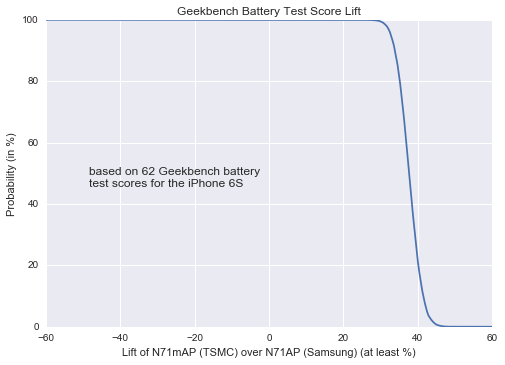

In [63]:
x = np.linspace(-.6, .599, 2000)
def get_prob(lift):
    return np.mean((samples_N71mAP - samples_N71AP) / samples_N71AP > lift)
v_get_prob = np.vectorize(get_prob)
prob = v_get_prob(x)
fig, ax = plt.subplots()
ax.set_title('Geekbench Battery Test Score Lift')
plt.plot(x*100, prob*100)
plt.xlabel(r'Lift of N71mAP (TSMC) over N71AP (Samsung) (at least %)')
plt.ylabel(r'Probability (in %)')
fig.text(.2, .45, """
based on 62 Geekbench battery
test scores for the iPhone 6S
""")